In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
from abtem.potentials.parametrizations import (
    KirklandParametrization,
    LobatoParametrization,
    PengParametrization,
)
from ase.io import read

(walkthrough:potentials)=
# Potentials
An electron beam interacts with a specimen (mainly) through the Coulomb potential of its electrons and nuclei. Thus the total electrostatic potential of the sample is required for image simulations. Typically, the so-called independent atom model (IAM) is used, which calculates the potential as a superposition of atomic potentials, hence neglecting effects due to bonding.

## Atomic potential parametrization

The electron charge distribution of a single atom can be calculated from a first-principles electronic structure calculation, for example using the [Hartree-Fock method](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) or [Density Functional Theory](https://en.wikipedia.org/wiki/Density_functional_theory). Given a charge distribution, the potential can be obtained via [Poisson's equation](https://en.wikipedia.org/wiki/Poisson%27s_equation). Most multislice simulation codes include a parametrization of the atomic potentials, with a table of parameters for each element fitted to the potential calculated from first principles. 

We show the radial dependence of the electrostatic potential of five selected elements below. Note, that the potentials goes to infinity at $r=0$.

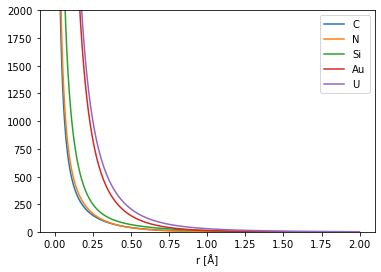

In [2]:
symbols = ["C", "N", "Si", "Au", "U"]

potentials = abtem.concatenate(
    [
        LobatoParametrization().line_profiles(
            symbol,
            cutoff=2,
            name="potential",
        )
        for symbol in symbols
    ]
)


ax = potentials.show()
ax.set_ylim([0, 2000]);

The default parametrization in abTEM, which is shown above, is created by Ivan Lobato{cite}`lobato-parameters`. We also implement the parametrization by Earl J. Kirkland{cite}`kirkland-parameters` and the parametrization by Peng{cite}`peng-parameters`. The differences between the parametrizations are generally negligible at low scattering angles, however, the parametrization by Lobato is more accurate at high scattering angles{cite}`lobato-parameters`.

# Independent atom model
The full specimen potential, $V(r)$, is usually obtained as a linear superposition of atomic potentials

$$
    V(r) = \sum_i V_i(r-r_i) \quad,
$$

where $V_i(r)$ is the atomic potential of the $i$'th atom. This is known as the Independent Atom Model (IAM). The IAM neglects bonding effects, which is usually a good approximation. However, in some special cases it is important to include bonding effects, see  our [introduction to charge transfer](charge_transfer.ipynb).

## The `Potential`
Here, we create a `Potential` representing an IAM potential of SrTiO<sub>3</sub> with the Lobato parametrization. The `sampling` denotes the spacing of the $xy$-samples of the potential, `slice_thickness` determines the spacing the slices in direction of electron beam and `projection` determines how those slices are calculated (as described [later in this document](walkthrough:potentials:slicing)). 

In [3]:
sto_lto_interface = read("./data/STO_LTO.cif")

potential = abtem.Potential(
    sto_lto_interface,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="finite",
)

The potential has 23 slices as may be determined from getting its length.

In [4]:
len(potential)

23

The projected potential, i.e. the sum of all the slices, may be shown using the `.show` method.

[########################################] | 100% Completed |  4.8s


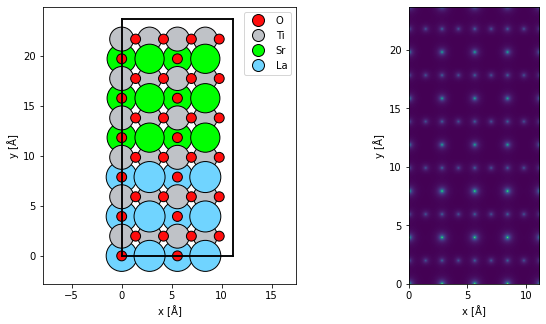

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(sto_lto_interface, ax=ax1, legend=True)
potential.show(ax=ax2);

The `Potential` may be indexed to return a subset of slices. Below we select the first 5 slices and show them all by setting `explode=True`.

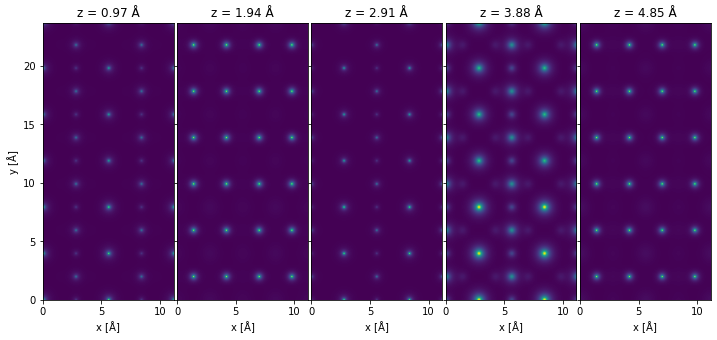

In [6]:
potential[:5].show(explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05});

## Building and saving the potential
The `Potential` object does not store the calculated potential slices. Hence, if a simulation, such as STEM requires multiple propagations, each slice have to be calculated multiple times. For this reason, abTEM often precalculates the potential, whenever it has to be used more than once. 

The potential can be precalculated manually using the `.build` method, however, it should typically be preferred to let abTEM decide whether to precalculate the potential.

In [7]:
potential_array = potential.build().compute()

[########################################] | 100% Completed |  3.8s


This returns an `PotentialArray` object, which stores each 2D potential slice in a 3D array. The first dimension is the slice index and the last two are the spatial dimensions.

In [8]:
potential_array.shape

(23, 224, 474)

The calculated potential can be stored in the `zarr` file format and read back.

In [9]:
potential_array.to_zarr("data/srtio3_110_potential.zarr", overwrite=True)

abtem.from_zarr("data/srtio3_110_potential.zarr");

(walkthrough:potentials:slicing) = 
## Slicing the potential

The multislice method requires a mathematical slicing of the potential and is only correct in the limit of thin slices, however, more slices increases the computational cost. A reasonable value for slice thickness is generally between $0.5 \ \mathrm{Å}$ and $2 \ \mathrm{Å}$. The default is $1 \ \mathrm{Å}$. abTEM provides multiple options for evaluating the integrals required for slicing the potential.

### Finite projection integrals

abTEM implements an accurate finite potential projection method. Numerical integration is used to calculate the integrals of the form

$$
V_{n}(x, y) = \int_{z_n}^{z_n+\Delta z} V(x,y,z) dz \quad ,
$$ (eq:potentials:slice)

where $z_n$ is the $z$-position at the entrance of the $n$'th slice and $\Delta z$ is the slice thickness.

We used `abTEM`s default method of handling finite projection integrals above, additional options and a description of the methods is given in appendix ???.

### Infinite projection integrals

Since the finite projection method can be computationally demanding abTEM also implements a potential using infinite projection integrals. The finite integrals are replaced by infinite integrals, which may be evaluated analytically

$$ \int_{-\infty}^{\infty} V(x,y,z) dz \approx \int_{z_i}^{z_i+\Delta z} V(x,y,z) dz $$

The infinite projection of the atomic potential for each atom is assigned to a single slice. The implementation uses the hybrid real-space/Fourier-space approach by W. van den Broek et. al. (https://doi.org/10.1016/j.ultramic.2015.07.005). Using infinite projections can be *much* faster, especially for potentials with a large numbers of atoms. The error introduced by using infinite integrals is negligible compared to other sources of error in most cases.

Below we create the same SrTiO3 potential as above with infinite projections. The potential looks almost identical to the finite projection, however, note that the slice at $z=3.88 \ \mathrm{Å}$ has zero intensity, because there is not atoms in this slice.

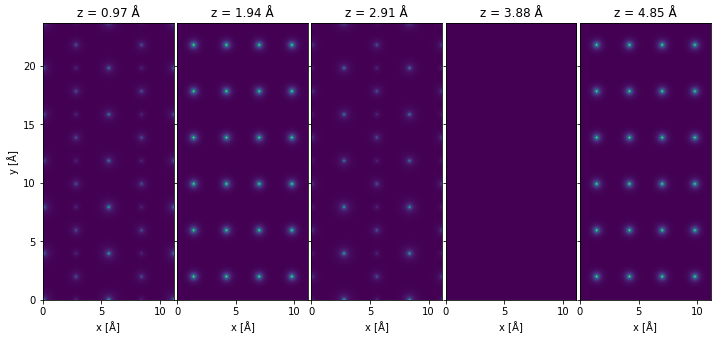

In [10]:
potential_infinite = abtem.Potential(
    sto_lto_interface,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="infinite",
)

potential_infinite[:5].show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05}
);

## Crystal potentials

Calculating the potential is generally not a significant cost for simulations where the same potential is used in many runs of the multislice algorithm. However, for simulations that require just one or a few wave functions, such as HRTEM and CBED, it is an advantage to use a `CrystalPotential`.

The `CrystalPotential` allows fast calculation for potentials of crystals by tiling a repeating unit of the cystal. We also implement a fast frozen phonon algorithm for crystal using by rearranging slices {cite}`drprobe`, see our introduction

In [11]:
potential_unit = abtem.Potential(sto_lto_interface, sampling=0.05, projection="finite")

crystal_potential = abtem.CrystalPotential(
    potential_unit=potential_unit, repetitions=(10, 10, 10)
)